In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# data importing
df = pd.read_excel("dataset.xlsx")

In [3]:
df.head(2)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820


In [4]:
df.shape

(2121, 21)

In [5]:
df_1=df.drop(['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City',
        'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity',
        'Discount', 'Profit'], axis=1)
df_1.head(3)

,Order Date,Sales
0,2016-11-08,261.9600
1,2016-11-08,731.9400
2,2015-10-11,957.5775


In [6]:
# Arrange the date
df_1['Order Date']=pd.to_datetime(df_1['Order Date'])

In [7]:
df_1.head(3)

,Order Date,Sales
0,2016-11-08,261.9600
1,2016-11-08,731.9400
2,2015-10-11,957.5775


In [8]:
# sort the date
df_1=df_1.sort_values('Order Date')

In [9]:
df_1.head(3)

,Order Date,Sales
1577,2014-01-06,2573.820
1626,2014-01-07,76.728
181,2014-01-10,51.940


In [10]:
df_1=df_1.set_index(['Order Date'])

In [11]:
df_1.head()

,Sales
Order Date,
2014-01-06,2573.820
2014-01-07,76.728
2014-01-10,51.940
2014-01-11,9.940
2014-01-13,545.940


In [12]:
 df_1.shape

(2121, 1)

In [13]:
# compile sales as per date
dataset=df_1.groupby('Order Date')['Sales'].sum().reset_index()

In [14]:
# reindexig the dataframe
dataset=dataset.set_index(['Order Date'])

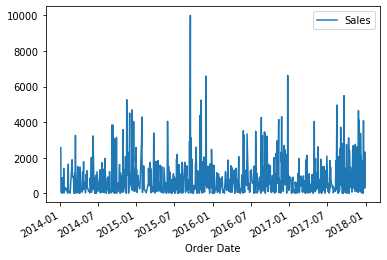

In [15]:
dataset.plot()

In [16]:
dataset.shape

(889, 1)

In [17]:
# resampling
Series_month=dataset['Sales'].resample('MS').mean()

In [18]:
Series_month.shape, type(Series_month)

((48,), pandas.core.series.Series)

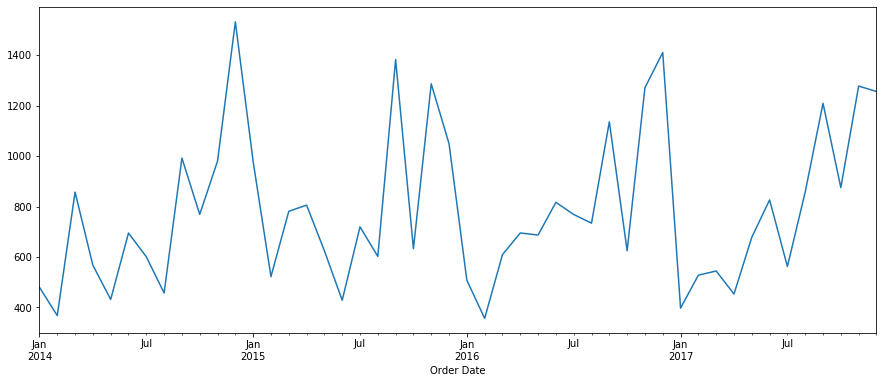

In [19]:
Series_month.plot(figsize=(15, 6))

In [20]:
df_month = pd.DataFrame(Series_month)
df_month.shape

(48, 1)

In [21]:
df_month.head()

,Sales
Order Date,
2014-01-01,480.194231
2014-02-01,367.931600
2014-03-01,857.291529
2014-04-01,567.488357
2014-05-01,432.049187


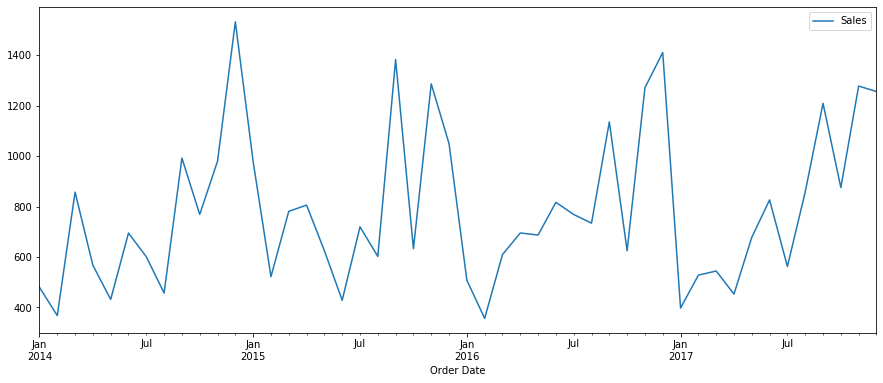

In [22]:
df_month.plot(figsize=(15, 6))

In [23]:
### Testing For Stationarity

from statsmodels.tsa.stattools import adfuller

test_result=adfuller(df_month['Sales'])


#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

In [24]:
adfuller_test(df_month['Sales'])

ADF Test Statistic : -5.191070187339269
p-value : 9.168756655665738e-06
#Lags Used : 10
Number of Observations Used : 37
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


# To find Q & P- value plot ACF & PACF 

In [25]:
# By observation we got q and p both 1 from the graph

C:\Users\ashish\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


Text(0.5, 1.0, 'Partial Autocorrelation Function')

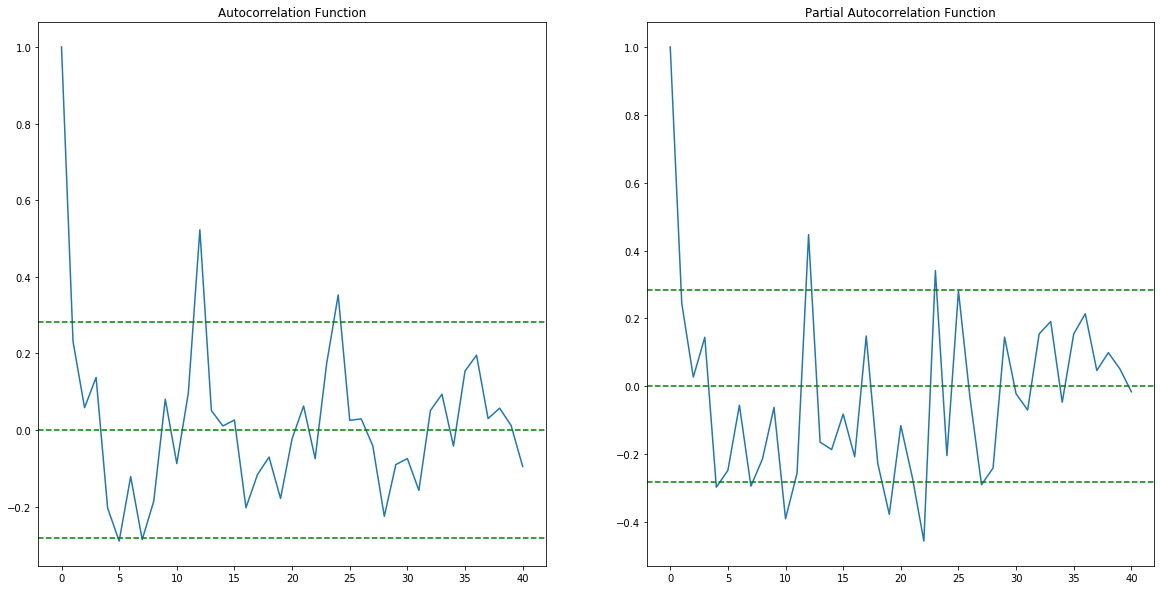

In [26]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf=acf(df_month)
lag_pacf=pacf(df_month, method='ols')

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(df_month)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(df_month)),linestyle='--',color='green')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(df_month)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(df_month)),linestyle='--',color='green')
plt.title('Partial Autocorrelation Function')

# SARIMAX

C:\Users\ashish\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


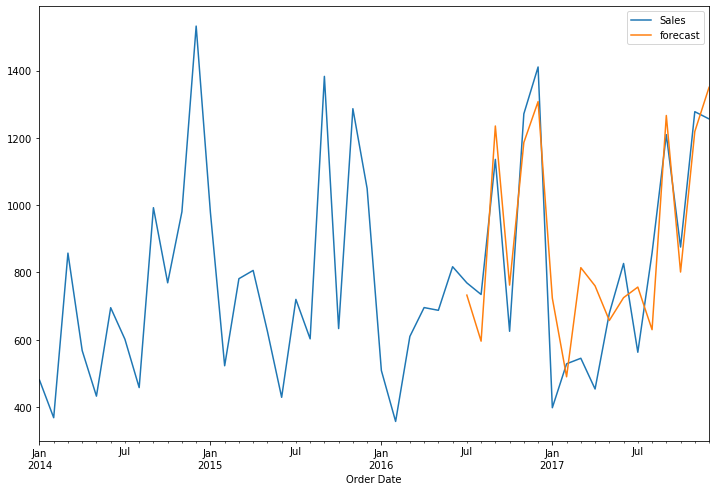

In [27]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df_month['Sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

df_month['forecast']=results.predict(start=30,end=47,dynamic=True)
df_month[['Sales','forecast']].plot(figsize=(12,8))

# Differencing

In [28]:
df_month['Sales First Difference'] = df_month['Sales'] - df_month['Sales'].shift(1)

In [29]:
df_month['Seasonal First Difference'] = df_month['Sales'] - df_month['Sales'].shift(12)

In [30]:
df_month.head(15)

,Sales,forecast,Sales First Difference,Seasonal First Difference
Order Date,,,,
2014-01-01,480.194231,NaN,NaN,NaN
2014-02-01,367.931600,NaN,-112.262631,NaN
2014-03-01,857.291529,NaN,489.359929,NaN
2014-04-01,567.488357,NaN,-289.803172,NaN
2014-05-01,432.049187,NaN,-135.439170,NaN
2014-06-01,695.059242,NaN,263.010055,NaN
2014-07-01,601.169500,NaN,-93.889742,NaN
2014-08-01,457.521656,NaN,-143.647844,NaN
2014-09-01,992.353367,NaN,534.831710,NaN


In [31]:
#adfuller_test(df_month['Seasonal First Difference'])

adfuller_test(df_month['Seasonal First Difference'].dropna())


ADF Test Statistic : -4.168949509959843
p-value : 0.000743344188520415
#Lags Used : 4
Number of Observations Used : 31
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [32]:
df_month.shape

(48, 4)

In [33]:
df_month.head(2)

,Sales,forecast,Sales First Difference,Seasonal First Difference
Order Date,,,,
2014-01-01,480.194231,NaN,NaN,NaN
2014-02-01,367.931600,NaN,-112.262631,NaN


C:\Users\ashish\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


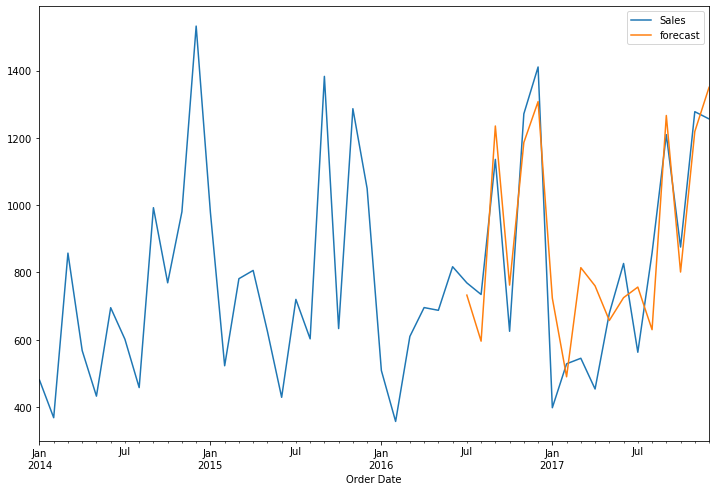

In [34]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df_month['Sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

df_month['forecast']=results.predict(start=30,end=47,dynamic=True)
df_month[['Sales','forecast']].plot(figsize=(12,8))

In [35]:
# seasonal_order

In [36]:
from pandas.tseries.offsets import DateOffset
future_dates=[df_month.index[-1]+ DateOffset(months=x)for x in range(0,24)]

In [37]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df_month.columns)

In [38]:
future_datest_df.tail()

,Sales,forecast,Sales First Difference,Seasonal First Difference
2019-07-01,NaN,NaN,NaN,NaN
2019-08-01,NaN,NaN,NaN,NaN
2019-09-01,NaN,NaN,NaN,NaN
2019-10-01,NaN,NaN,NaN,NaN
2019-11-01,NaN,NaN,NaN,NaN


In [39]:
future_df=pd.concat([df_month,future_datest_df])

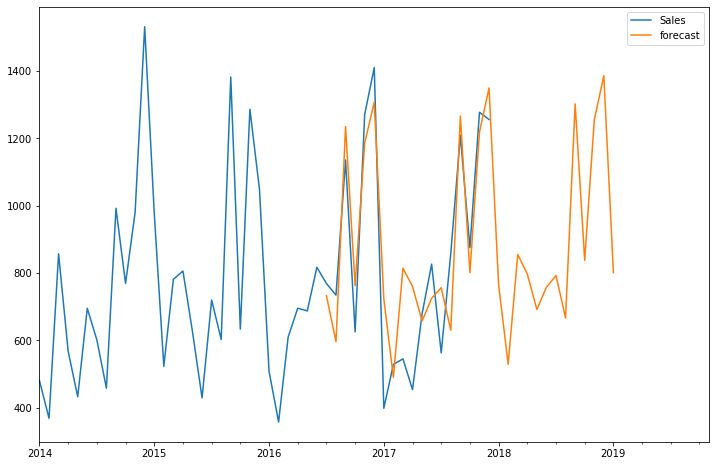

In [42]:
future_df['forecast'] = results.predict(start = 30, end = 60, dynamic= True)  
future_df[['Sales', 'forecast']].plot(figsize=(12, 8)) 